In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joypy
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Loading the cleaned dataset

In [2]:
data_species = pd.read_csv('../Data/cleaned_data.csv', index_col=0)

data = data_species.copy(deep=True)
data.dropna(inplace=True)

## Splitting by data category

Here we split the data between numerical and categorical data

In [3]:
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

categorical_data = data.loc[:,categorical_columns].copy(deep=True)
numerical_data = data.loc[:, numerical_columns].copy(deep=True)

## Numerical data

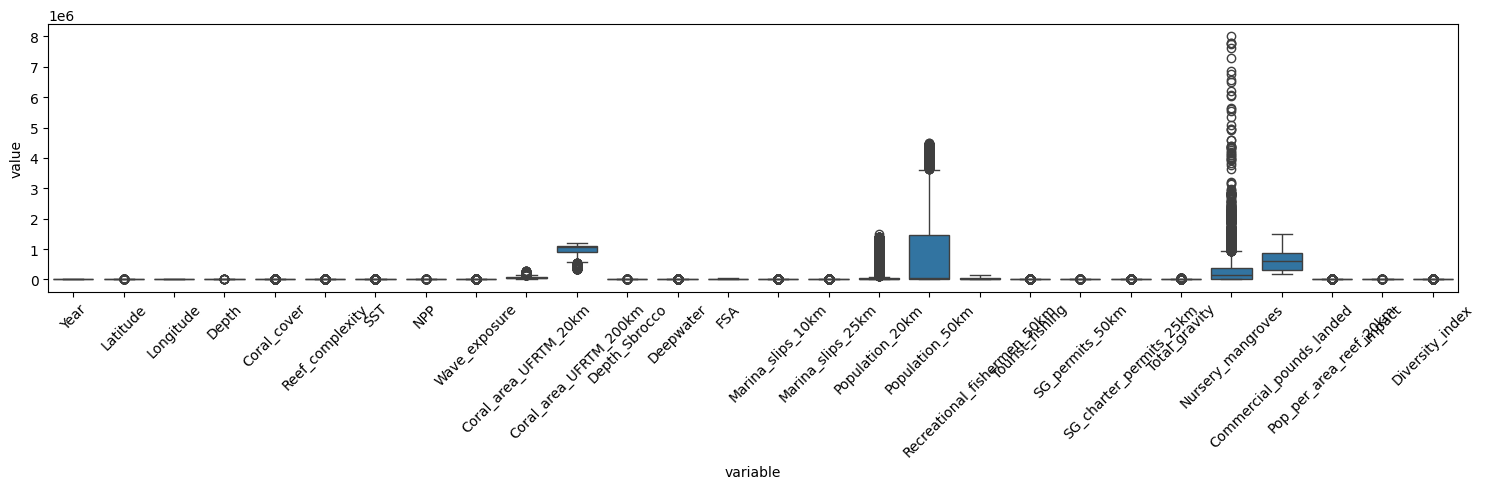

In [4]:
sns.color_palette("mako", as_cmap=True)
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes = sns.boxplot(x="variable", y="value",
            data=pd.melt(numerical_data))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that the ranges of data is very different, so we want to rescale them to see which data have outliers

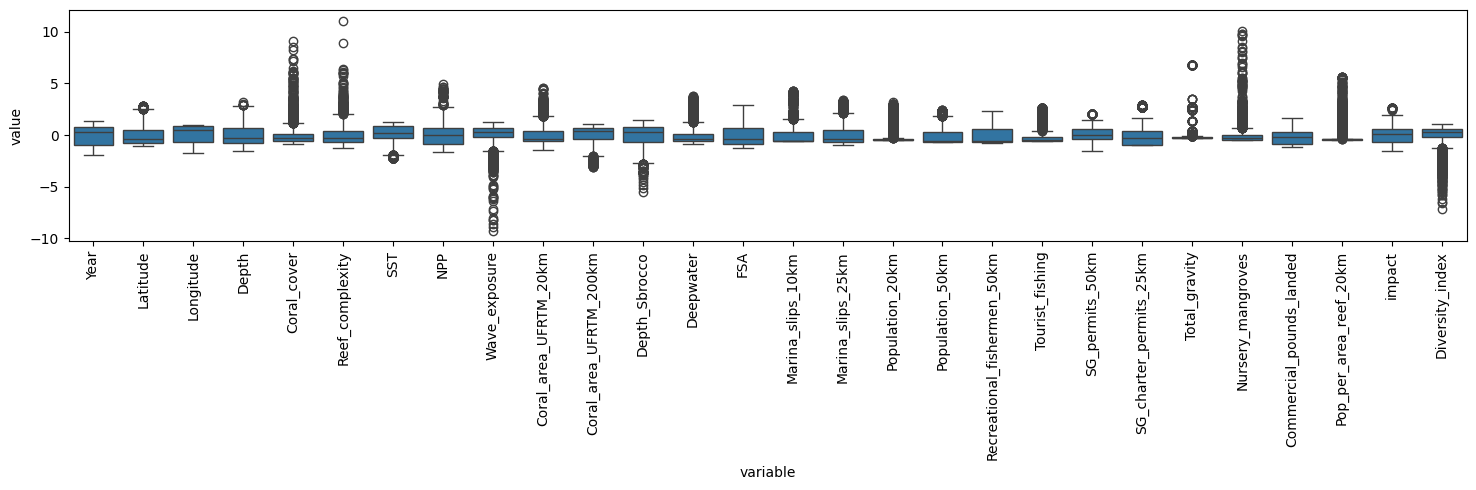

In [5]:
ct = ColumnTransformer([
        ('somename', StandardScaler(), numerical_data.columns)
    ], remainder='drop')

scaled_numerical_data = pd.DataFrame(ct.fit_transform(numerical_data))
scaled_numerical_data.columns = numerical_data.columns

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes = sns.boxplot(x="variable", y="value",
            data=pd.melt(scaled_numerical_data))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Some variables, which could be of interest, have a lot of outliers in one direction: Coral_cover, Reef_Complexity, Wave exposure, Diversity_index. We want to understand those outliers and decide what to do with them. Are they bad data or actual points?

In [6]:
# Compute Z Score
def calculate_zscore(series):
    diversity_mean = np.nanmean(series.values.tolist())
    diversity_std = np.nanstd(series.values.tolist())
    return (series  - diversity_mean ) / diversity_std

column_interest = ['Coral_cover','Reef_complexity','Wave_exposure','Diversity_index']

for interest in column_interest:
    scaled_numerical_data[f'zscore_{interest}'] = calculate_zscore(scaled_numerical_data[interest])


Checking wave exposure outliers

In [7]:
threshold = 2

zscore_columns = [f'zscore_{i}' for i in column_interest]

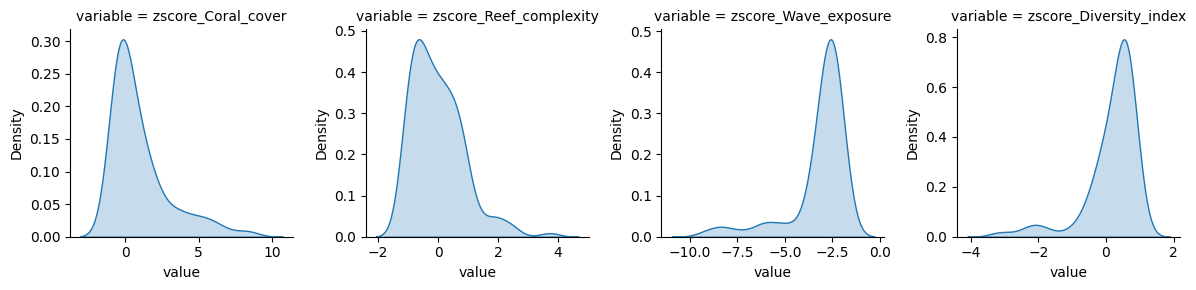

In [8]:
wave_exposure_outliers = scaled_numerical_data.loc[scaled_numerical_data.zscore_Wave_exposure<-threshold,zscore_columns]

# Create the grid of KDE plots
g = sns.FacetGrid(wave_exposure_outliers.melt(), col='variable', col_wrap=4, height=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True)

# Show the plots
plt.tight_layout()
plt.show()

The wave outliers seems to have a weak link with the Diversity index and some of the Coral cover

Coral_cover outliers

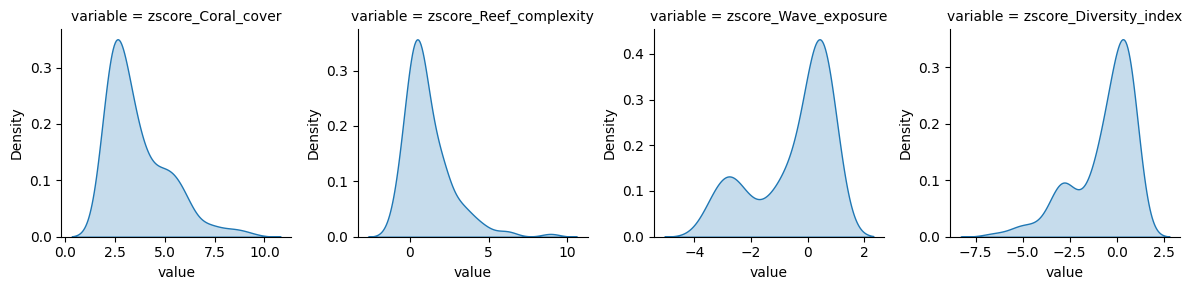

In [9]:
coral_cover_outliers = scaled_numerical_data.loc[scaled_numerical_data.zscore_Coral_cover>2,zscore_columns]

# Create the grid of KDE plots
g = sns.FacetGrid(coral_cover_outliers.melt(), col='variable', col_wrap=4, height=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True)

# Show the plots
plt.tight_layout()
plt.show()

We see that the Coral cover outliers have a direct link with the Diversity and Wave exposure (both density are clearly bi modal), and some of the outliers in Coral cover correspond to outliers in Wave exposure and Diversity index. It would mean that we should probably not remove the outliers.

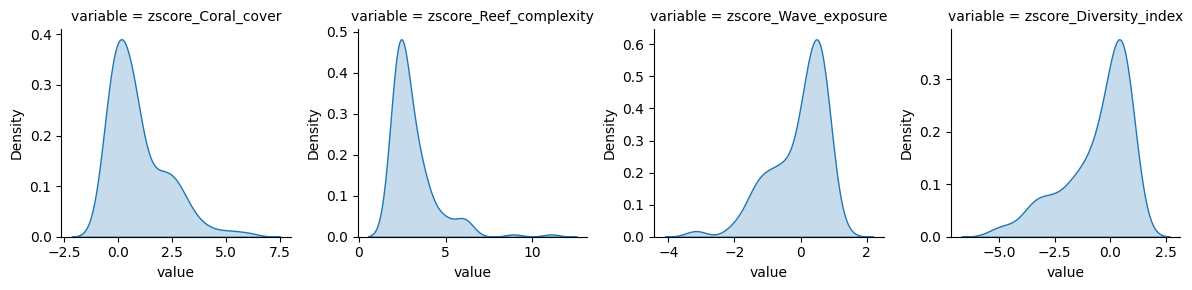

In [10]:
reef_complexity_outliers = scaled_numerical_data.loc[scaled_numerical_data.zscore_Reef_complexity>2,zscore_columns]

# Create the grid of KDE plots
g = sns.FacetGrid(reef_complexity_outliers.melt(), col='variable', col_wrap=4, height=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True)

# Show the plots
plt.tight_layout()
plt.show()

The analysis is the same there.<br> It also helps us see a relationship between those 4 variables. Outliers in one of them seems to correspond to some outliers in another one. Let's look if we select all the data with outliers in Coral_cover, Reef_complexity and Wave_exposure. Do we get the outliers in Diversity index?

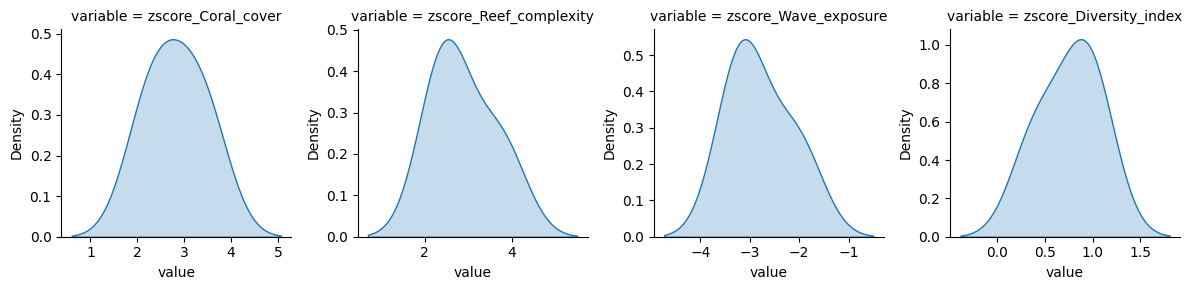

In [11]:

cat_3_outliers = scaled_numerical_data.loc[(scaled_numerical_data.zscore_Reef_complexity>threshold) & (scaled_numerical_data.zscore_Coral_cover>threshold) & (scaled_numerical_data.zscore_Wave_exposure<-threshold),zscore_columns]

# Create the grid of KDE plots
g = sns.FacetGrid(cat_3_outliers.melt(), col='variable', col_wrap=4, height=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True)

# Show the plots
plt.tight_layout()
plt.show()

We can infer that outliers in all 3 categories have a direct impact on the zscore of the Diversity index. So it means the 3 categories have a relationship on the Diversity index (the higher Coral cover and Reef complexity and the lower Wave exposure, the higher the Diversity index).
<br>
But we see that they do not grab the outliers of Diversity index (when Diversity index is very low)
<br>
We propose to some of the outliers of Diversity index (threshold > 3) to have cleaner distributions

In [12]:
index_to_keep = scaled_numerical_data.loc[scaled_numerical_data.zscore_Diversity_index>-3,:].index

In [13]:
data_cleaned_of_outliers = numerical_data.iloc[index_to_keep,:]

## Working on skewed data

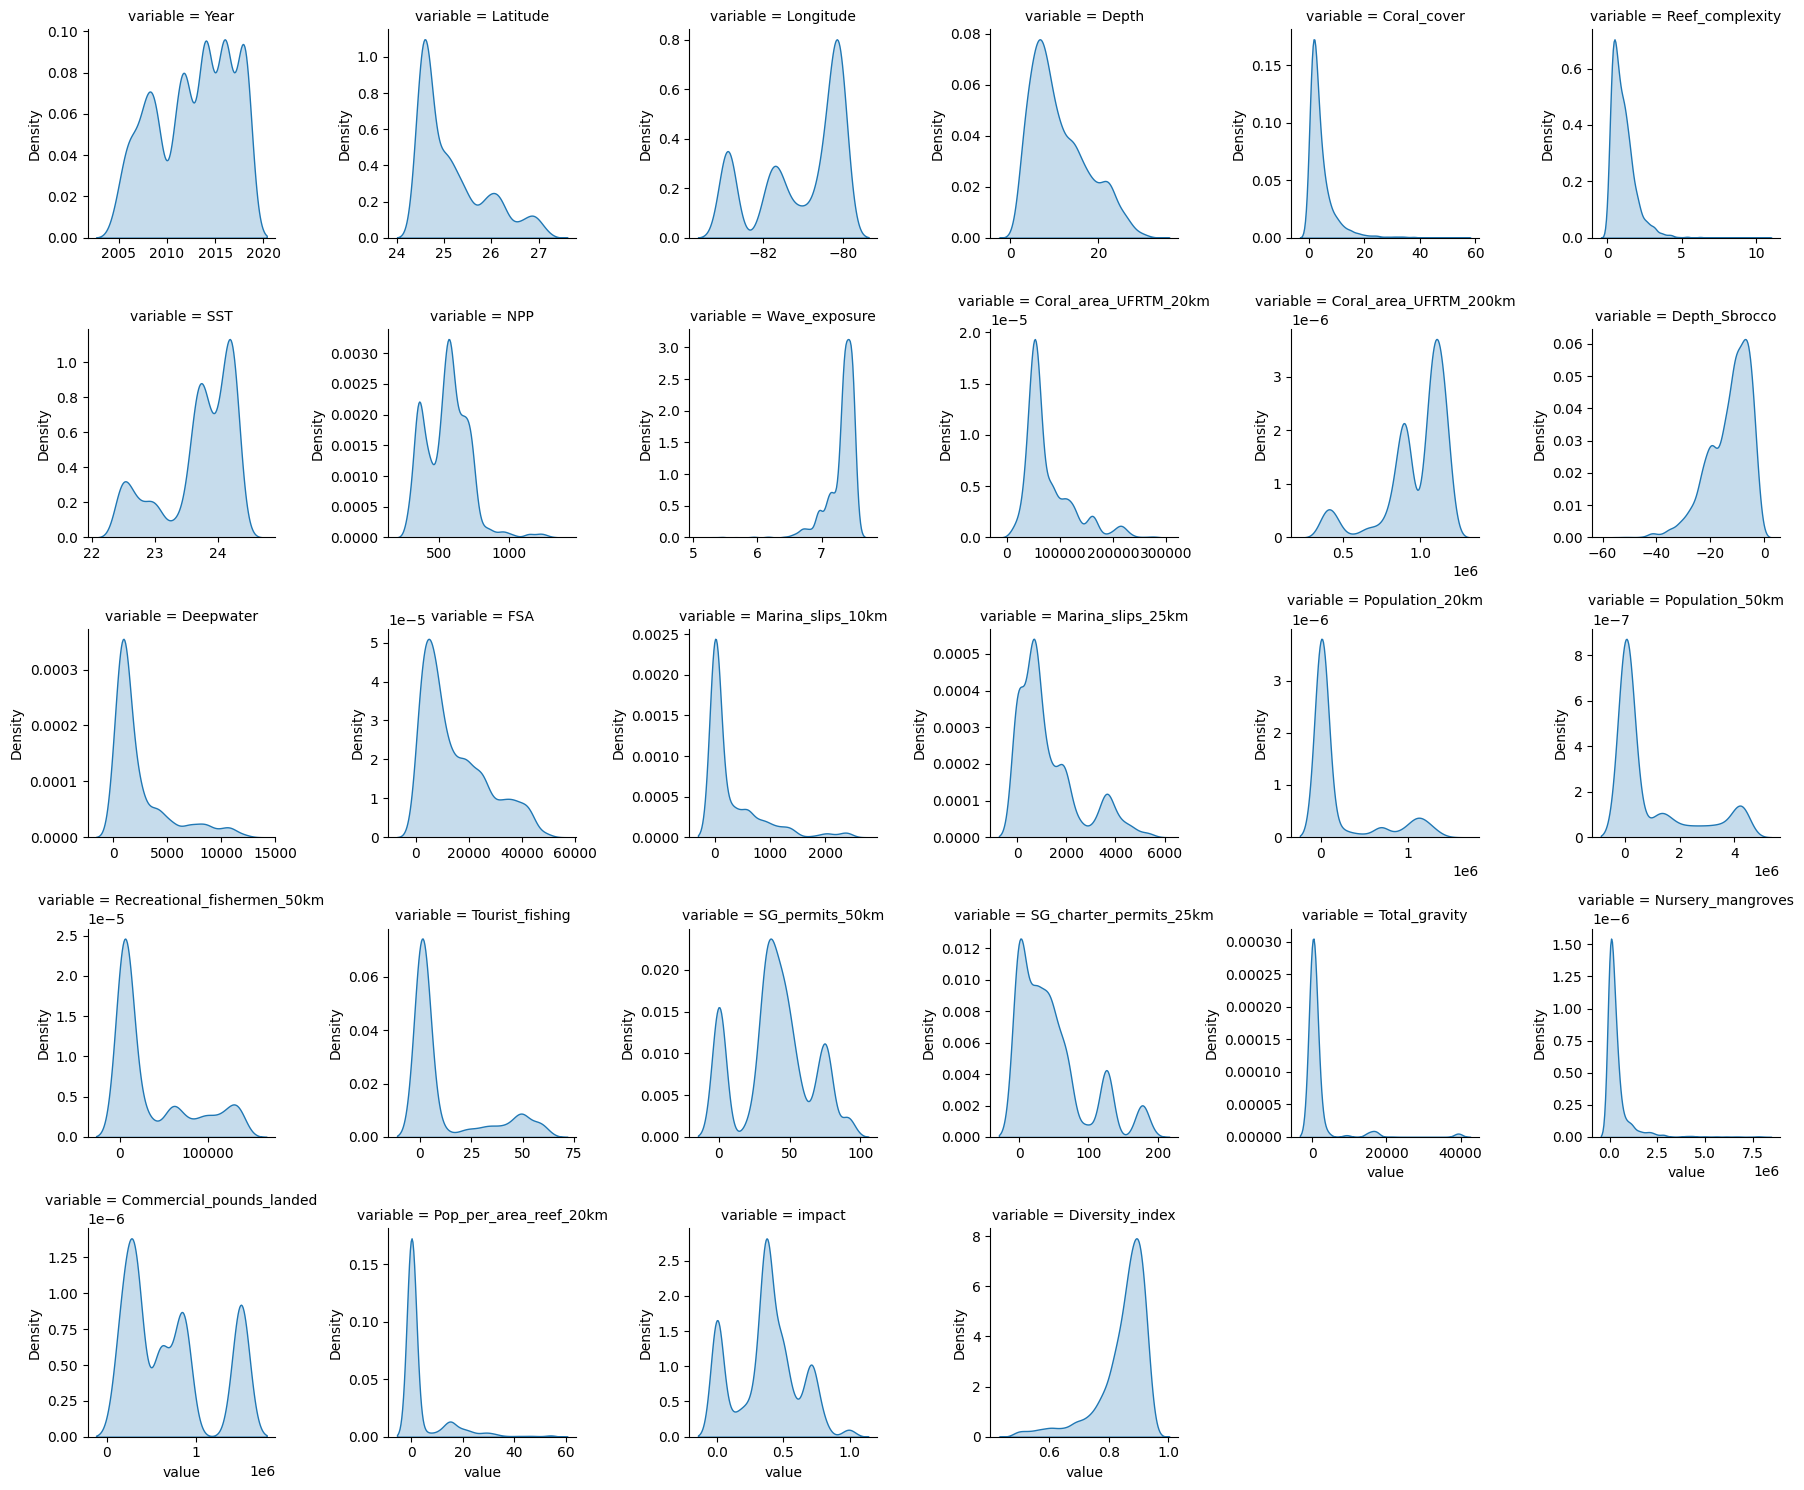

In [14]:
# Create the grid of KDE plots
g = sns.FacetGrid(data_cleaned_of_outliers.melt(), col='variable', col_wrap=6, height=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True)

# Show the plots
plt.tight_layout()
plt.show()

We see that some data are very skewed<br>
- Left tail: Diversity index, Wave exposure
- Right tail: Pop per area 20km, Nursery mangroves, total gravity, Tourist fishing, Coral area 20km, Coral cover, Reef complexity

Those data will need some transformation. The standard transformation we can apply is to use a log transform. A log transform requires the data to be positve. So to change the left skewed data into a right skewed data we can apply max(column) - data.
<br>
Then on all the data we can to transform, we can add a small epsilon (10-5) to ensure positiveness

In [19]:
def left_to_right(series):
    max_data = np.max(series)
    return max_data - series

left_tail = ['Diversity_index','Wave_exposure']

for c in left_tail:
    data_cleaned_of_outliers[f'right_{c}'] = left_to_right(data_cleaned_of_outliers.loc[:,c])

right_tail = ['Reef_complexity','Coral_cover','right_Diversity_index','right_Wave_exposure','Total_gravity','Tourist_fishing','Nursery_mangroves','Coral_area_UFRTM_20km','Pop_per_area_reef_20km']

for r in right_tail:
    data_cleaned_of_outliers.loc[:,r] = data_cleaned_of_outliers.loc[:,r] + 10**-5
    data_cleaned_of_outliers[f'transformed_{r}'] = np.log(data_cleaned_of_outliers.loc[:,r])

C:\Users\GuillaumePealat\AppData\Local\Temp\ipykernel_13012\2060151561.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_of_outliers[f'right_{c}'] = left_to_right(data_cleaned_of_outliers.loc[:,c])
C:\Users\GuillaumePealat\AppData\Local\Temp\ipykernel_13012\2060151561.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_of_outliers[f'transformed_{r}'] = np.log(data_cleaned_of_outliers.loc[:,r])
C:\Users\GuillaumePealat\AppData\Local\Temp\ipykernel_13012\2060151561.py:14: SettingW

We select the data we want to keep at this stage. And we replot the density.

In [21]:
selected_columns = ['Year', 'Depth',  'SST', 'NPP', 
       'Depth_Sbrocco','Deepwater', 'FSA', 'Marina_slips_10km', 'Marina_slips_25km',
       'Population_20km', 'Population_50km', 'Recreational_fishermen_50km',
        'SG_permits_50km', 'SG_charter_permits_25km',
       'Total_gravity',  'Commercial_pounds_landed','impact',
       'transformed_Wave_exposure', 'transformed_right_Diversity_index',
       'transformed_right_Wave_exposure', 'transformed_Total_gravity',
       'transformed_Tourist_fishing', 'transformed_Nursery_mangroves',
       'transformed_Coral_area_UFRTM_20km',
       'transformed_Pop_per_area_reef_20km','transformed_Reef_complexity',
       'transformed_Coral_cover']

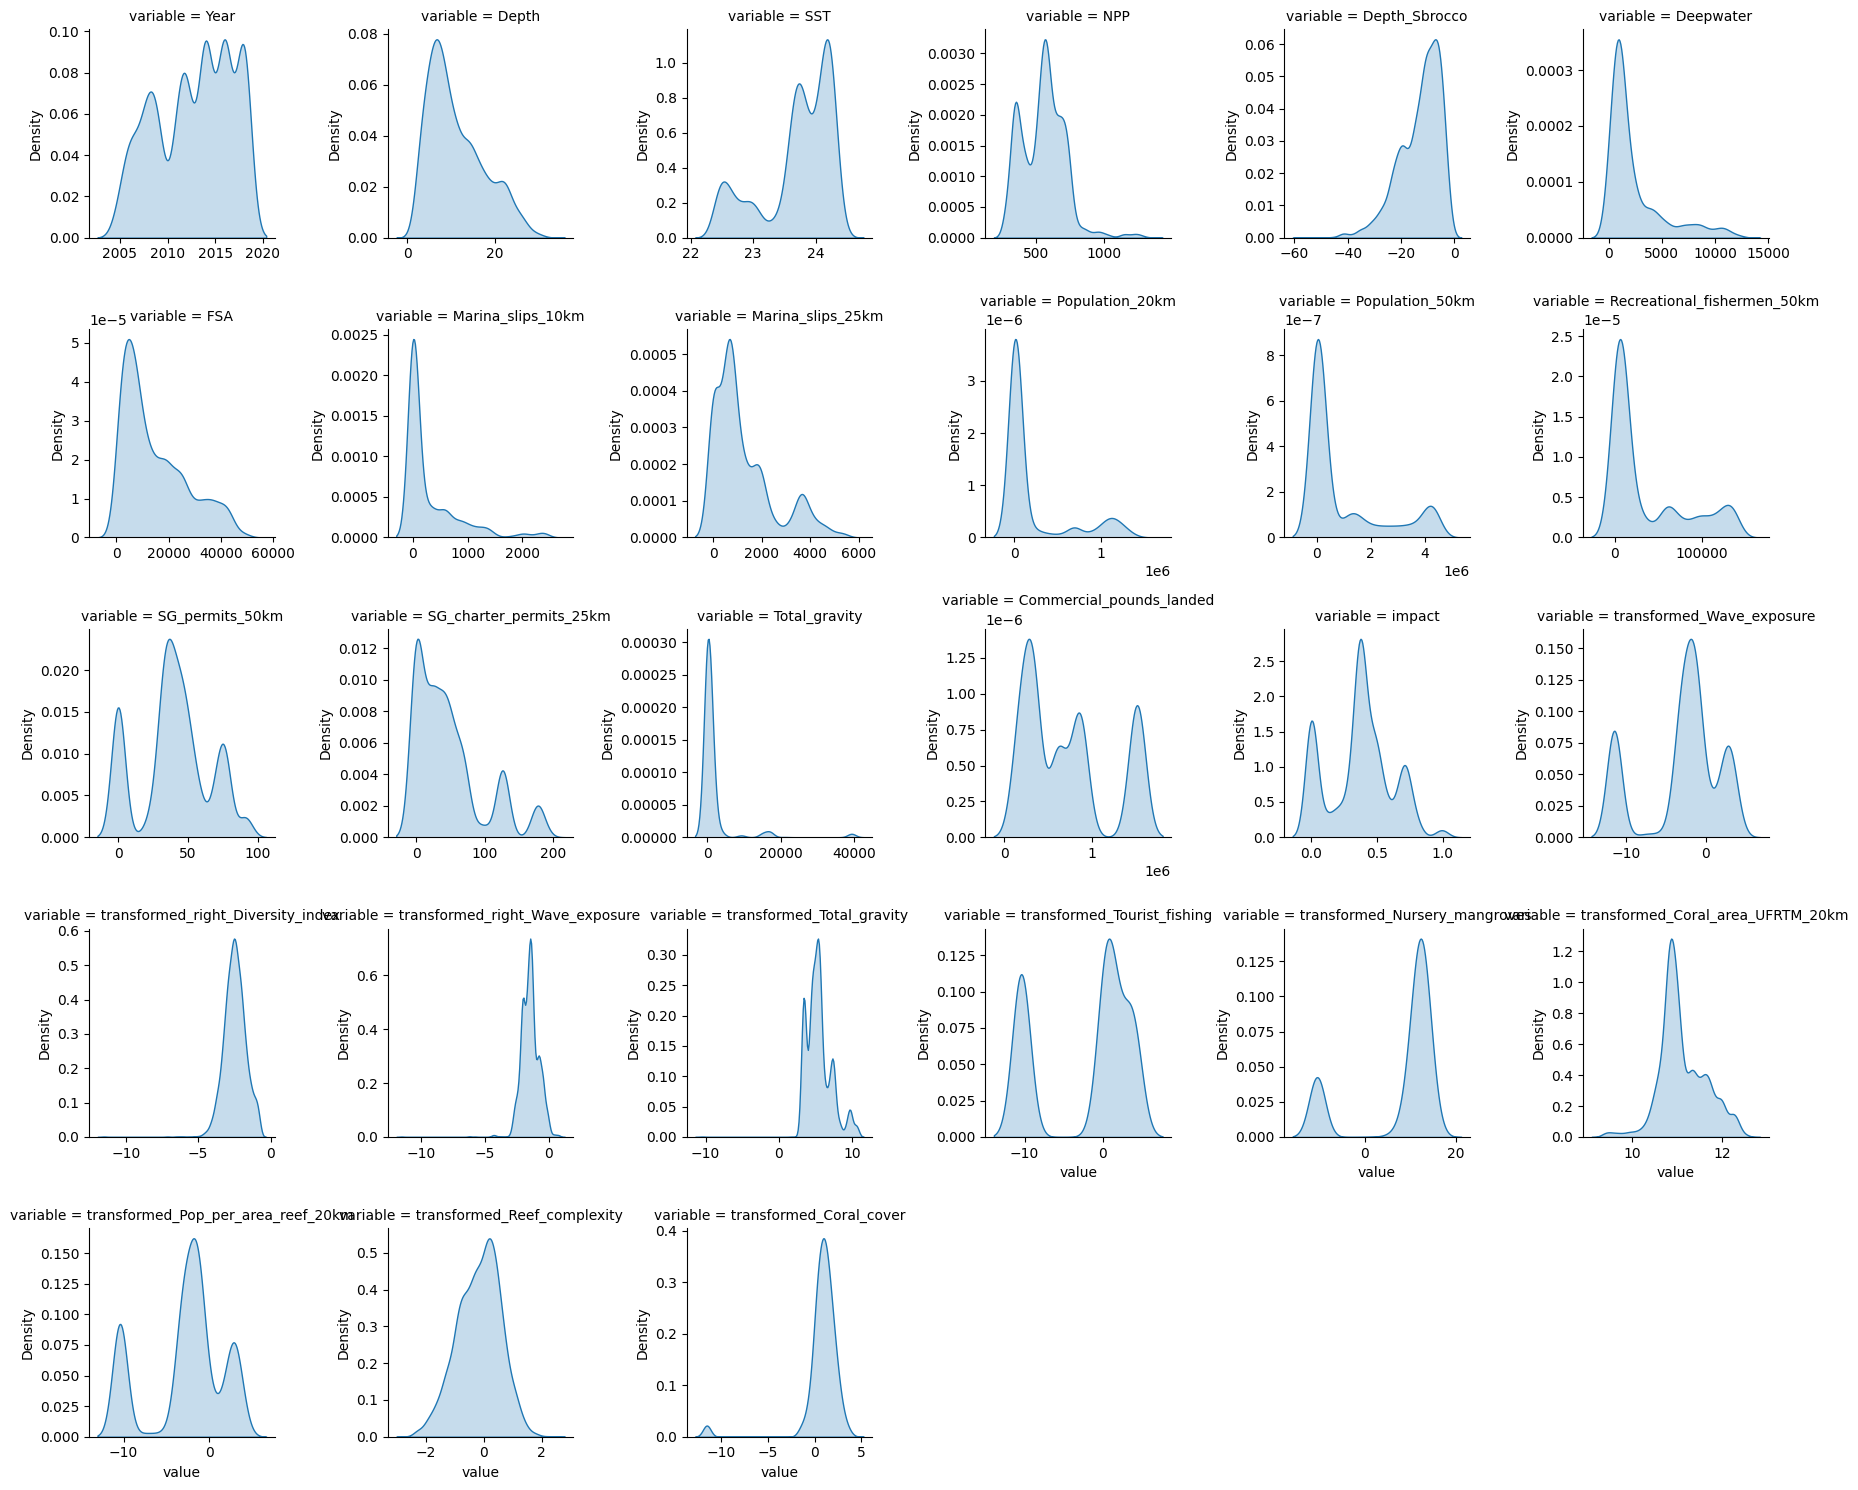

In [23]:
# Create the grid of KDE plots
data_features = data_cleaned_of_outliers[selected_columns]
g = sns.FacetGrid(data_features.melt(), col='variable', col_wrap=6, height=3, sharex=False, sharey=False)
g.map(sns.kdeplot, 'value', fill=True)

# Show the plots
plt.tight_layout()
plt.show()

We can see that the distributions are closer to normal (with outliers still). The scale of the data are still very different. We will apply a scaler to have comparable data

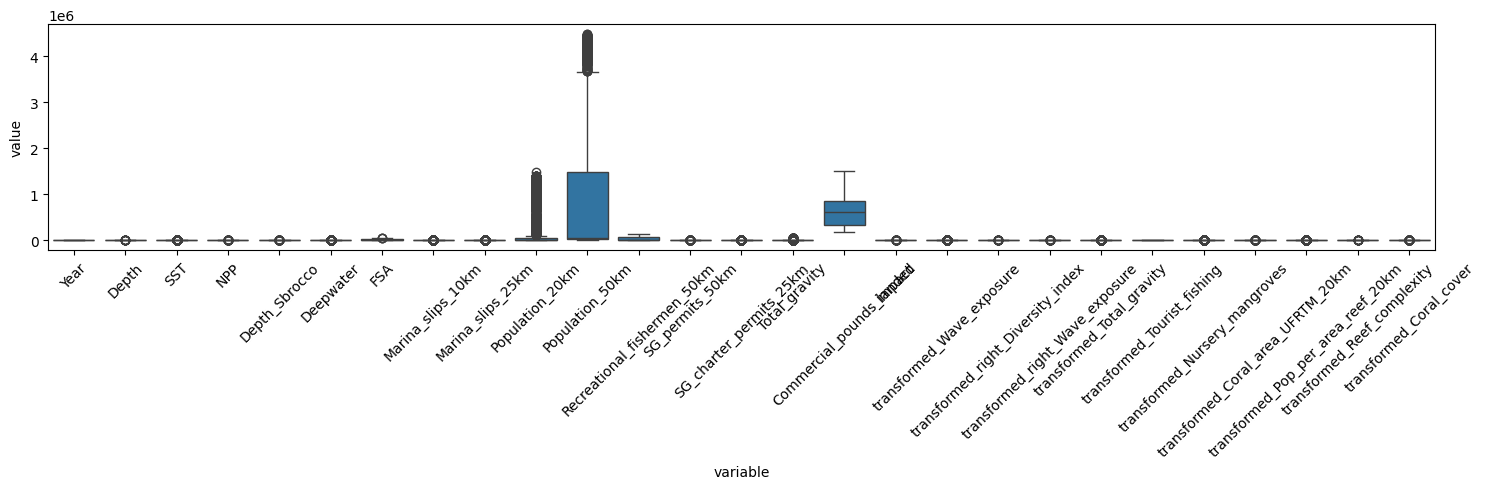

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(15, 5))
axes = sns.boxplot(x="variable", y="value",
            data=pd.melt(data_features))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

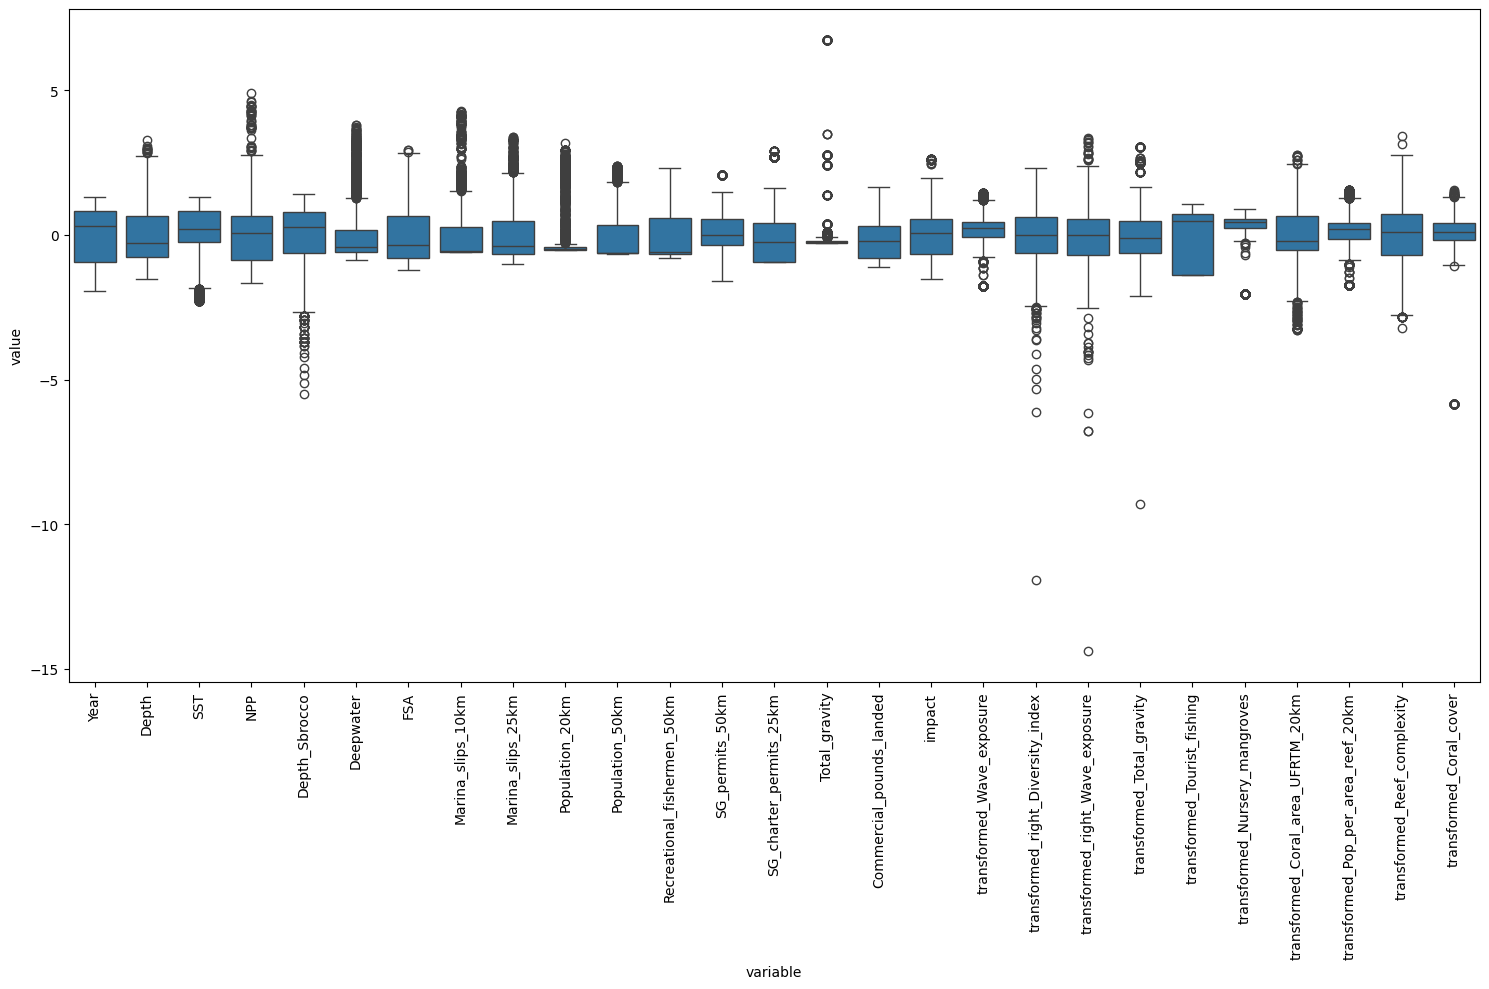

In [27]:
ct = ColumnTransformer([
        ('somename', StandardScaler(), data_features.columns)
    ], remainder='drop')

scaled_data_features = pd.DataFrame(ct.fit_transform(data_features))
scaled_data_features.columns = data_features.columns

fig, axes = plt.subplots(1, 1, figsize=(15, 10))
axes = sns.boxplot(x="variable", y="value",
            data=pd.melt(scaled_data_features))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

We can see here that some data will not be very usefull as their variations are too small:
- Population_20km
- Total_gravity
<br>We will drop them from our data

In [28]:
scaled_data_features.drop(columns=['Population_20km','Total_gravity'], inplace=True)

In [29]:
data.to_csv("../Data/features.csv")